构建一个以日为单位，分时的订单客流高峰预测器，预测每个区域的订单客流。结合天气数据


Pre—process data

In [4]:
import pyarrow.parquet as pq
import pandas as pd
import shapely, geopandas, fiona

In [5]:
path = pq.read_table('/Users/dingjiadong/Desktop/uber/NYC TLC/fhvhv_tripdata_2021-01.parquet')
path = path.to_pandas()

In [6]:
weather = pd.read_csv('/Users/dingjiadong/Desktop/uber/NYC TLC/nyc 2021-01-01 to 2021-12-31.csv')
weather.head()
weather['datetime'] = pd.to_datetime(weather['datetime'])
weather_jan = weather[weather['datetime']<'2021-02-01']
weather_jan.head()

,name,address,resolvedAddress,datetime,temp,feelslike,dew,humidity,precip,precipprob,...,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,uvindex,severerisk
0,nyc,nyc,"New York, NY, United States",2021-01-01,2.5,-0.2,-3.0,67.8,15.33,100,...,0.0,0.0,NaN,15.5,69.8,1028.9,50.6,14.0,3,NaN
1,nyc,nyc,"New York, NY, United States",2021-01-02,5.8,3.6,1.2,74.0,2.38,100,...,1.9,0.6,54.6,25.5,246.9,1012.4,63.9,12.2,5,NaN
2,nyc,nyc,"New York, NY, United States",2021-01-03,2.5,-1.6,-0.5,80.7,5.09,100,...,1.2,1.7,42.2,24.1,66.4,1017.0,81.5,13.2,1,NaN
3,nyc,nyc,"New York, NY, United States",2021-01-04,3.6,1.1,-0.2,76.6,0.84,100,...,0.5,0.7,NaN,17.3,141.1,1014.6,89.3,15.6,4,NaN
4,nyc,nyc,"New York, NY, United States",2021-01-05,3.8,1.3,-1.5,68.7,0.00,0,...,0.0,0.1,31.7,15.2,124.4,1013.1,98.8,16.0,2,NaN


In [7]:
path['datetime'] = pd.to_datetime(path['pickup_datetime'])
path['datetime'] = path['datetime'].dt.date
path['datetime'] = pd.to_datetime(path['datetime'])
path = path[['datetime','pickup_datetime','dropoff_datetime','PULocationID','DOLocationID']]
path.datetime

0          2021-01-01
1          2021-01-01
2          2021-01-01
3          2021-01-01
4          2021-01-01
              ...    
11908463   2021-01-31
11908464   2021-01-31
11908465   2021-01-31
11908466   2021-01-31
11908467   2021-01-31
Name: datetime, Length: 11908468, dtype: datetime64[ns]

In [8]:
path_wx = pd.merge(path, weather_jan, left_on='datetime',right_on='datetime')
path_wx.head()

,datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,name,address,resolvedAddress,temp,feelslike,...,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,uvindex,severerisk
0,2021-01-01,2021-01-01 00:33:44,2021-01-01 00:49:07,230,166,nyc,nyc,"New York, NY, United States",2.5,-0.2,...,0.0,0.0,NaN,15.5,69.8,1028.9,50.6,14.0,3,NaN
1,2021-01-01,2021-01-01 00:55:19,2021-01-01 01:18:21,152,167,nyc,nyc,"New York, NY, United States",2.5,-0.2,...,0.0,0.0,NaN,15.5,69.8,1028.9,50.6,14.0,3,NaN
2,2021-01-01,2021-01-01 00:23:56,2021-01-01 00:38:05,233,142,nyc,nyc,"New York, NY, United States",2.5,-0.2,...,0.0,0.0,NaN,15.5,69.8,1028.9,50.6,14.0,3,NaN
3,2021-01-01,2021-01-01 00:42:51,2021-01-01 00:45:50,142,143,nyc,nyc,"New York, NY, United States",2.5,-0.2,...,0.0,0.0,NaN,15.5,69.8,1028.9,50.6,14.0,3,NaN
4,2021-01-01,2021-01-01 00:48:14,2021-01-01 01:08:42,143,78,nyc,nyc,"New York, NY, United States",2.5,-0.2,...,0.0,0.0,NaN,15.5,69.8,1028.9,50.6,14.0,3,NaN


In [9]:
# len(path_wx)-path_wx.count()check missing values

In [10]:
pw = path_wx.groupby('PULocationID',as_index=False).size()

In [11]:
shp_df = geopandas.read_file('/Users/dingjiadong/Desktop/uber/NYC TLC/taxi_zones/taxi_zones.shp')
shp_df['geometry'] = shp_df['geometry'].to_crs('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')#转为经纬度

In [12]:
pw = pd.merge(path_wx, shp_df,left_on='PULocationID',right_on='LocationID')

In [14]:
path_wx_jan = pw[['datetime','pickup_datetime','PULocationID','zone','temp','precip','snow']]
path_wx_jan.head()

,datetime,pickup_datetime,PULocationID,zone,temp,precip,snow
0,2021-01-01,2021-01-01 00:33:44,230,Times Sq/Theatre District,2.5,15.33,0.0
1,2021-01-01,2021-01-01 00:47:11,230,Times Sq/Theatre District,2.5,15.33,0.0
2,2021-01-01,2021-01-01 00:36:20,230,Times Sq/Theatre District,2.5,15.33,0.0
3,2021-01-01,2021-01-01 00:19:54,230,Times Sq/Theatre District,2.5,15.33,0.0
4,2021-01-01,2021-01-01 00:46:03,230,Times Sq/Theatre District,2.5,15.33,0.0


In [15]:
path_wx_jan['hour'] = path_wx_jan['pickup_datetime'].dt.hour

/var/folders/tv/qqztgq5x3mg6qcpqqfx53jp40000gn/T/ipykernel_3214/751872218.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path_wx_jan['hour'] = path_wx_jan['pickup_datetime'].dt.hour


In [16]:
path_wx_jan.tail()

,datetime,pickup_datetime,PULocationID,zone,temp,precip,snow,hour
11947087,2021-01-26,2021-01-26 10:44:25,110,Great Kills Park,0.9,2.66,1.2,10
11947088,2021-01-26,2021-01-26 16:32:03,110,Great Kills Park,0.9,2.66,1.2,16
11947089,2021-01-31,2021-01-31 09:55:27,110,Great Kills Park,-4.9,1.96,10.0,9
11947090,2021-01-06,2021-01-06 11:07:25,199,Rikers Island,3.0,0.00,0.0,11
11947091,2021-01-06,2021-01-06 16:15:12,199,Rikers Island,3.0,0.00,0.0,16


In [17]:
path_wx_jan = path_wx_jan.groupby(['datetime','hour','PULocationID'],as_index=False).size()

In [18]:
weather_jan = weather_jan[['temp','precip','snow','windspeed','datetime']]
path_wx_jan = pd.merge(path_wx_jan, weather_jan,left_on='datetime', right_on='datetime')

In [19]:
path_wx_jan['day'] = path_wx_jan['datetime'].dt.day
path_wx_jan.tail()

,datetime,hour,PULocationID,size,temp,precip,snow,windspeed,day
184318,2021-01-31,23,259,51,-4.9,1.96,10.0,27.5,31
184319,2021-01-31,23,260,58,-4.9,1.96,10.0,27.5,31
184320,2021-01-31,23,261,24,-4.9,1.96,10.0,27.5,31
184321,2021-01-31,23,262,42,-4.9,1.96,10.0,27.5,31
184322,2021-01-31,23,263,53,-4.9,1.96,10.0,27.5,31


In [20]:
path_wx_jan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184323 entries, 0 to 184322
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   datetime      184323 non-null  datetime64[ns]
 1   hour          184323 non-null  int64         
 2   PULocationID  184323 non-null  int64         
 3   size          184323 non-null  int64         
 4   temp          184323 non-null  float64       
 5   precip        184323 non-null  float64       
 6   snow          184323 non-null  float64       
 7   windspeed     184323 non-null  float64       
 8   day           184323 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(4)
memory usage: 14.1 MB


Convert pickup id to dummies

In [21]:
cate_var = path_wx_jan['PULocationID']
dummies = pd.get_dummies(cate_var)
dummies.columns = [str(i) for i in dummies.columns]
dummies.head()

,1,2,3,4,5,6,7,8,9,10,...,254,255,256,257,258,259,260,261,262,263
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
data1 = pd.concat([path_wx_jan, dummies], axis=1)
data1.drop(['PULocationID','datetime'], inplace=True, axis=1)
data1.head()

,hour,size,temp,precip,snow,windspeed,day,1,2,3,...,254,255,256,257,258,259,260,261,262,263
0,0,80,2.5,15.33,0.0,15.5,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,138,2.5,15.33,0.0,15.5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,11,2.5,15.33,0.0,15.5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,21,2.5,15.33,0.0,15.5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,249,2.5,15.33,0.0,15.5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Linear Regression 

In [23]:
predi = data1[['size']] #y
predi.head()

,size
0,80
1,138
2,11
3,21
4,249


In [24]:
obs = data1[[i for i in data1.columns if i not in ['size']]] #x
obs.head()

,hour,temp,precip,snow,windspeed,day,1,2,3,4,...,254,255,256,257,258,259,260,261,262,263
0,0,2.5,15.33,0.0,15.5,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,2.5,15.33,0.0,15.5,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,2.5,15.33,0.0,15.5,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2.5,15.33,0.0,15.5,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,2.5,15.33,0.0,15.5,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
import numpy as np
from scipy import stats
import sklearn
import sklearn.model_selection as ms
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

ols = linear_model.LinearRegression()


In [26]:
x_train, x_test, y_train, y_test = ms.train_test_split(obs, predi, test_size=2.0/10, random_state=0)
ols.fit(x_train, y_train)

LinearRegression()

In [27]:
print('training MSE:',(mean_squared_error(y_train, ols.predict(x_train)))**0.5)
print('training R^2:',ols.score(x_train, y_train))

training MSE: 37.35913676062858
training R^2: 0.6573990702520783


In [28]:
print('testing MSE:',(mean_squared_error(y_test, ols.predict(x_test)))**0.5)
print('testing R^2:',ols.score(x_test, y_test))

testing MSE: 37.35048802185308
testing R^2: 0.6504782812454493


Lasso

In [29]:
from sklearn.linear_model import Lasso
lass = Lasso().fit(x_train,y_train)

In [30]:
y_train_pred = lass.predict(x_train)
y_test_pred = lass.predict(x_test)

In [31]:
print('training MSE:',(mean_squared_error(y_train, y_train_pred))**0.5)
print('training r^2:',r2_score(y_train, y_train_pred))

training MSE: 61.12078709890102
training r^2: 0.08299279363074252


In [32]:
print('testing MSE:',(mean_squared_error(y_test, y_test_pred))**0.5)
print('testing r^2:',r2_score(y_test, y_test_pred))

testing MSE: 60.50812749898084
testing r^2: 0.08270498650379099


Hpyerparameter tunning

In [33]:
from sklearn.linear_model import LassoCV
import time

n_folds = 5
alphas = np.logspace(-4, -0.5, 30)

start = time.time()
las_cv = LassoCV(cv = n_folds, alphas = alphas, max_iter = 10000, random_state = 0)
las_cv.fit(x_train,y_train)
end = time.time()

print('LassoCV execution time: {}'.format(end - start))
print('LassoCV best params: {}\n'.format(las_cv.alpha_))


/Users/dingjiadong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LassoCV execution time: 97.11323070526123
LassoCV best params: 0.0001



In [34]:
y_train_pred = las_cv.predict(x_train)
y_test_pred = las_cv.predict(x_test)

In [35]:
print('training MSE:',(mean_squared_error(y_train, y_train_pred))**0.5)
print('training r^2:',r2_score(y_train, y_train_pred))

training MSE: 37.358931131482656
training r^2: 0.657402841674483


In [36]:
print('testing MSE:',(mean_squared_error(y_test, y_test_pred))**0.5)
print('testing r^2:',r2_score(y_test, y_test_pred))

testing MSE: 37.35002604475952
testing r^2: 0.6504869274526464


In [37]:
###lasso and linear regression's performence is about the same

CART

In [38]:
from sklearn.ensemble import RandomForestRegressor

In [39]:
RFR = RandomForestRegressor(max_features=14,n_estimators=100)
rfr = RFR.fit(x_train, y_train)

/var/folders/tv/qqztgq5x3mg6qcpqqfx53jp40000gn/T/ipykernel_3214/2394519755.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr = RFR.fit(x_train, y_train)


In [40]:
y_train_predr = rfr.predict(x_train)
y_test_predr = rfr.predict(x_test)

In [41]:
print('training MSE:',(mean_squared_error(y_train, y_train_predr))**0.5)
print('training r^2:',r2_score(y_train, y_train_predr))

training MSE: 6.08140699507554
training r^2: 0.9909217317668989


In [42]:
print('testing MSE:',(mean_squared_error(y_test, y_test_predr))**0.5)
print('testing r^2:',r2_score(y_test, y_test_predr))

testing MSE: 16.197829899690838
testing r^2: 0.9342652109092612


Visualise

In [43]:
### significant imporvement by random forest

In [44]:
x_train.columns

Index(['hour', 'temp', 'precip', 'snow', 'windspeed', 'day', '1', '2', '3',
       '4',
       ...
       '254', '255', '256', '257', '258', '259', '260', '261', '262', '263'],
      dtype='object', length=265)

In [45]:
len(RFR.feature_importances_)

265

In [46]:
imp_df = pd.DataFrame({'features':x_train.columns,'importance':RFR.feature_importances_})
imp_df.head()

,features,importance
0,hour,0.231079
1,temp,0.021838
2,precip,0.011222
3,snow,0.006125
4,windspeed,0.020530


In [47]:
imp_df = imp_df.sort_values(by='importance',ascending= False)
imp_df.head(10)

,features,importance
0,hour,0.231079
65,61,0.059813
80,76,0.033596
5,day,0.027361
47,42,0.024266
1,temp,0.021838
42,37,0.021372
4,windspeed,0.020530
83,79,0.014478
22,17,0.014067


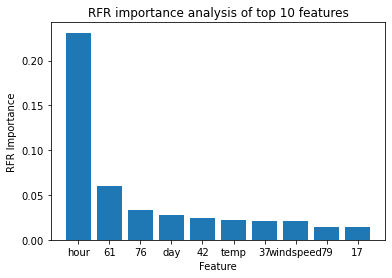

<Figure size 720x360 with 0 Axes>

In [48]:
import matplotlib.pyplot as plt

x = np.arange(1,11)
y = imp_df[0:10]['importance']

labels = imp_df[0:10].features

plt.figure()
plt.bar(x, y)
plt.xticks(x, labels)
plt.xlabel('Feature')
plt.ylabel('RFR Importance')
plt.title('RFR importance analysis of top 10 features')
fig = plt.figure(figsize=(10,5))
fig.autofmt_xdate(rotation = 60)


plt.show()

In [49]:
### The plot above shows the top 10 important features. The variable hour, day, temp and windspeed
### are quite important. Furthermore, the plot suggests some locations are important as well. 
### For exapmle, locationID 61 has the second most important.

XGBoost

In [50]:
import xgboost as xgb

In [51]:
xgbr = xgb.XGBRFRegressor(objective='reg:squarederror')
xgbt = xgbr.fit(x_train, y_train)

y_train_predx = xgbt.predict(x_train)
y_test_predx = xgbt.predict(x_test)

In [52]:
print('training MSE:',(mean_squared_error(y_train, y_train_predx))**0.5)
print('training r^2:',r2_score(y_train, y_train_predx))

training MSE: 53.40351401761116
training r^2: 0.2999411631140044


In [53]:
print('testing MSE:',(mean_squared_error(y_test, y_test_predx))**0.5)
print('testing r^2:',r2_score(y_test, y_test_predx))

testing MSE: 53.46734208211605
testing r^2: 0.28375962847619707


Hyperparameter tunning

In [59]:
from sklearn.model_selection import GridSearchCV

params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [300],
           'colsample_bytree': [0.3, 0.7]}
xgbr = xgb.XGBRegressor(seed = 20)

clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
clf.fit(x_train,y_train)

print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
Lowest RMSE:  34.043467974179784


In [61]:
clf.best_params_


{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 10,
 'n_estimators': 100}

In [94]:
(-clf.best_score_)**0.5

18.873593907380542

continue tunning

In [95]:
params = { 'max_depth': [8,10],
           'learning_rate': [0.1,0.15],
           'n_estimators': [300],
           'colsample_bytree': [0.7,0.8]}
xgbr = xgb.XGBRegressor(seed = 20)

clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
clf.fit(x_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


KeyboardInterrupt: 

In [ ]:
clf.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.15,
 'max_depth': 10,
 'n_estimators': 300}

In [98]:
XGB = xgb.XGBRegressor(max_depth=10,learning_rate=0.15,n_estimators=300,colsample_bytree=0.8)
XGB.fit(x_train,y_train)

y_train_predx2 = XGB.predict(x_train)
y_test_predx2 = XGB.predict(x_test)

In [99]:
print('training MSE:',(mean_squared_error(y_train, y_train_predx2))**0.5)
print('training r^2:',r2_score(y_train, y_train_predx2))

training MSE: 15.531540461556009
training r^2: 0.9407860630757168


In [100]:
print('testing MSE:',(mean_squared_error(y_test, y_test_predx2))**0.5)
print('testing r^2:',r2_score(y_test, y_test_predx2))

testing MSE: 18.457475340529903
testing r^2: 0.9146455438125076


Results

Model	            RMSE	     R^2
Linear regression	37.35	     0.65
lasso	            37.35	     0.65
CART(RF)	        16.2	     0.93
XGBoost		        18.45        0.91

RF has the best performence, and it only takes a fairly short time. XGBoost has the second best results, and it can achieve better results, but it requires hyperparameter tuning which takes a very long time.

In [105]:
### use all data training
from sklearn.ensemble import RandomForestRegressor
RFR = RandomForestRegressor(max_features=14,n_estimators=100)
rfr = RFR.fit(obs, predi)


/var/folders/tv/qqztgq5x3mg6qcpqqfx53jp40000gn/T/ipykernel_3214/2029439127.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr = RFR.fit(obs, predi)
